In [1]:
import pickle
import copy

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import numpy.typing as npt
from rich.progress import track
from rich import progress, console
from scipy import constants, interpolate
import IPython

from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
)
from centrex_trajectories.visualization import plot_beamline
from centrex_tlf import states, hamiltonian
from centrex_trajectories.utils import fit_stark_potential
from eigenshuffle import eigenshuffle_eigh


In [2]:
plt.rcParams.update({"font.size": 14})


In [3]:
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{(task.speed or 0):.1f}/s"
        else:
            return f"{(1 / task.speed or 0):.1f} s/i"


# Setup
## Generate Stark Potentials

In [4]:
# generate states up to J=6
QN = states.generate_uncoupled_states_ground(Js=np.arange(7))

# generate the X hamiltonian terms
H = hamiltonian.generate_uncoupled_hamiltonian_X(QN)

# create a function outputting the hamiltonian as a function of E and B
Hfunc = hamiltonian.generate_uncoupled_hamiltonian_X_function(H)

# V/cm
Ez = np.linspace(0, 50e3, 2_001)

# generate the Hamiltonian for (almost) zero field, add a small field to make states
# non-degenerate
Hi = Hfunc(E=[0, 0, 1e-3], B=[0, 0, 1e-3])
E, V = np.linalg.eigh(Hi)

# run eigenshuffle to track the states
Ez = np.append(np.linspace(0, 1_000, 501), np.linspace(2_000, 50_000, 51))
hamiltonians = np.array([Hfunc(E=[0, 0, Ei], B=[0, 0, 1e-3]) for Ei in Ez])
es, vs = eigenshuffle_eigh(hamiltonians)

# get the true superposition-states of the system
QN_states = hamiltonian.matrix_to_states(vs[0], QN)


In [5]:
indices_J2 = [idx for idx, s in enumerate(QN_states) if s.largest.J == 2]

indices_J2_F3 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)
indices_J2_other = [idx for idx in indices_J2 if idx not in indices_J2_F3]

indices_J2_mF0 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 0 and qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

indices_J2_mF2 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 2 and qn.largest.F == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)

indices_J2_mF3 = (
    indices_J2[0]
    + np.where(
        [
            qn.largest.mF == 3
            for qn in [
                qn.remove_small_components().transform_to_coupled()
                for qn in np.array(QN_states)[indices_J2]
            ]
        ]
    )[0]
)


In [6]:
# convert to V/m
Ez_Vm = Ez * 100

# grab energy of J=2, mF=0, 2 & 3
# mF=-1,0,1 have more or less the same energy levels, just slight differences at higher
# fields
energy = es.real[:, indices_J2_mF0[0]] * constants.hbar
fit_coeff_mF0 = fit_stark_potential(Ez_Vm, energy, deg=11)

energy = es.real[:, indices_J2_mF2[0]] * constants.hbar
fit_coeff_mF2 = fit_stark_potential(Ez_Vm, energy, deg=11)

energy = es.real[:, indices_J2_mF3[0]] * constants.hbar
fit_coeff_mF3 = fit_stark_potential(Ez_Vm, energy, deg=11)


## Beamline Setup

In [7]:
options = PropagationOptions(verbose=False, n_cores=8)
particle = TlF()
gravity = Gravity(0, -9.81 * particle.mass, 0)

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters current aperture
wx = 13e-3
wy = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 3

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_reducer_flange = (3 + 1 / 8 + 7 / 8) * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_radius = 0.011


# acme freezing distribution modified to our cell opening size (0.25" vs 5 mm for ACME)
sigma_x = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution
sigma_y = 0.25 * 25.4 / 5 * 3.8e-3  # Sigma for the gaussian position distribution


## Beamline Sections

| What | Length |
| --- | --- |  
| bs flange | 3/4" |
| center of the RC chamber to the beamsource front | 16-3/8" |
| center of the SPA chamber to the beamsource front | 28-3/8" |
| front of the EQL chamber to the beamsource front | 36" |
| lens chamber length | 24-5/8" |
| lens electrode length | 0.6 m |
| lens flange with o-ring | 7/8" |
| lens reducer | 3-1/8" |
| center of DET to start chamber | 5-1/4" |
| long nipple length | 39" |
| rc chamber length without flanges | 10.5" |
| rc chamber front without flanges to front bs flange | 10-3/8" |
| rc aperture from center rc | 3.56" | 
| rc aperture radius | 0.011 m |

In [8]:
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

rc = Section(
    name="Rotational cooling",
    objects=[
        CircularAperture(
            x=0,
            y=0,
            z=bbexit.stop + rc_chamber_center_from_bs_front + rc_aperture_from_center,
            r=rc_aperture_radius,
        )
    ],
    start=bbexit.stop
    + bs_flange
    + rc_chamber_center_from_bs_front
    - rc_chamber_length_no_flanges / 2,
    stop=bbexit.stop
    + rc_chamber_center_from_bs_front
    + rc_chamber_length_no_flanges / 2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)

spa = Section(
    name="State Prep A",
    objects=[],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
)
eql = ElectrostaticQuadrupoleLens(
    name="Electrostatic Lens",
    objects=[
        Bore(
            x=0,
            y=0,
            z=bbexit.stop
            + distance_lens_bbexit
            + (lens_chamber_length - lens_electrode_length) / 2,
            length=lens_electrode_length,
            radius=R,
        )
    ],
    start=bbexit.stop
    + distance_lens_bbexit
    + (lens_chamber_length - lens_electrode_length) / 2,
    stop=bbexit.stop
    + distance_lens_bbexit
    + lens_chamber_length
    - (lens_chamber_length - lens_electrode_length) / 2,
    V=V,
    R=R,
    save_collisions=True,
)
det = Section(
    name="Detection",
    objects=[
        RectangularAperture(
            0,
            0,
            eql.stop
            + lens_reducer_flange
            + n_nipples * nipple_length
            + +10.5 * in_to_m
            + distance_det_center
            + 0.001,
            wx,
            wy,
        )
    ],
    start=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center,
    stop=eql.stop
    + lens_reducer_flange
    + n_nipples * nipple_length
    + 10.5 * in_to_m
    + distance_det_center
    + 1e-2,
    save_collisions=False,
    propagation_type=PropagationType.ballistic,
    force=None,
)


In [9]:
def lens_scan_function(
    origin: Coordinates,
    velocities: Velocities,
    voltage: float,
    detection_laser_distance: float,
    detection_aperture_distance: float,
    length: float = 0.6,
    radius: float = 0.022225,
    stark_potential: npt.NDArray[np.float64] = fit_coeff_mF0,
):
    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=lens_electrode_length,
                radius=radius,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2
        + length,
        V=voltage,
        R=radius,
        save_collisions=False,
        stark_potential=stark_potential,
    )
    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + detection_aperture_distance,
                wx,
                wy,
            )
        ],
        start=eql.stop + detection_aperture_distance - 1e-3,
        stop=eql.stop + detection_laser_distance,
        save_collisions=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [fourK, fourtyK, bbexit, rc, spa, eql, det]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections


## Initialize distribution

In [10]:
n_trajectories = 20_000_000

origin = Coordinates(
    x=np.random.randn(n_trajectories) * sigma_x,
    y=np.random.randn(n_trajectories) * sigma_y,
    z=np.zeros(n_trajectories),
)
velocities_base = Velocities(
    vx=np.random.randn(n_trajectories) * 39.4,
    vy=np.random.randn(n_trajectories) * 39.4,
    vz=np.random.randn(n_trajectories) * 16,
)


# Scan

In [12]:
voltages = (
    np.array(
        [0.0, 10.0, 15.0, 20.0, 21.25, 22.5, 23.75, 25.0, 26.25, 27.5, 28.75, 30.0]
    )
    * 1e3
)
vforwards = np.arange(170, 192, 2)

data = dict(
    [(vforward, {"mF=0": [], "mF=2": [], "mF=3": []}) for vforward in vforwards]
)

with progress.Progress() as pb:
    t1 = pb.add_task("vforward", total=len(vforwards))
    t2 = pb.add_task("mF", total=3)
    t3 = pb.add_task("voltage", total=len(voltages))
    for idz, vforward in enumerate(vforwards):
        velocities = copy.deepcopy(velocities_base)
        velocities.vz += vforward
        for idx, (mf, start_coeff) in enumerate(
            zip(["mF=0", "mF=2", "mF=3"], [fit_coeff_mF0, fit_coeff_mF2, fit_coeff_mF3])
        ):
            for idy, voltage in enumerate(voltages):
                data[vforward][mf].append(
                    lens_scan_function(
                        origin,
                        velocities,
                        voltage,
                        detection_laser_distance=lens_reducer_flange
                        + n_nipples * nipple_length
                        + 10.5 * in_to_m
                        + distance_det_center,
                        detection_aperture_distance=lens_reducer_flange
                        + n_nipples * nipple_length
                        + distance_det_center
                        + 10.5 * in_to_m
                        - 1 * in_to_m,
                        stark_potential=start_coeff,
                    )
                )
                pb.update(task_id=t3, completed=idy + 1, refresh=True)
            pb.update(task_id=t2, completed=idx + 1, refresh=True)
        pb.update(task_id=t1, completed=idz + 1, refresh=True)
    pb.refresh()


Output()

In [13]:
with open("lens_scan_vforward_data_2025_4_29_vf_5m_s.pickle", "wb") as f:
    pickle.dump(data, f)

# Visualize

## mF=0 only

In [14]:
nr_survived = np.array([[len(d[1]) for d in dat["mF=0"]] for key, dat in data.items()])
nr_survived_error = np.sqrt(nr_survived)
gains = nr_survived / nr_survived[:, 0][:, np.newaxis]
gains_error = gains * np.sqrt(1 / nr_survived + 1 / nr_survived[0])

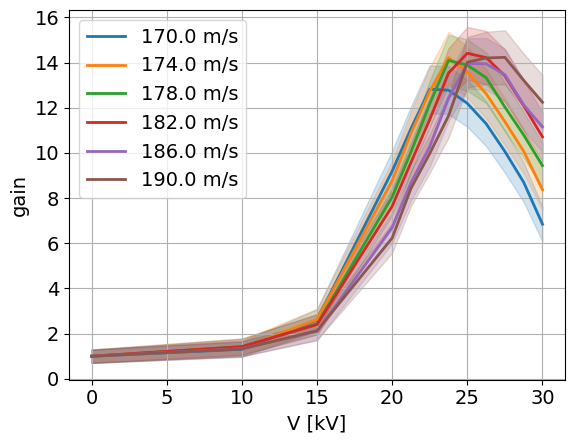

In [15]:
sl = np.s_[::2]
fig, ax = plt.subplots()
for vf, g, ge in zip(vforwards[sl], gains[sl], gains_error[sl]):
    (l,) = ax.plot(voltages / 1e3, g, lw=2, label=f"{vf:.1f} m/s")
    ax.fill_between(
        voltages / 1e3,
        g - 2 * ge,
        g + 2 * ge,
        alpha=0.2,
        edgecolor=l.get_color(),
        facecolor=l.get_color(),
    )

ax.set_xlabel("V [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid()

In [16]:
interpolations = dict(
    [
        (
            voltage,
            interpolate.CubicSpline(
                list(
                    data.keys(),
                ),
                nr_surv,
                extrapolate=False,
            ),
        )
        for voltage, nr_surv in zip(xpos, nr_survived.T)
    ]
)

NameError: name 'xpos' is not defined

In [ ]:
amplitude = np.ptp(list(data.keys())) / 2
mean = np.mean(list(data.keys()))

nr_survived_average = np.array(
    [
        np.mean(func(amplitude * np.sin(np.linspace(0, 2 * np.pi, 101)) + mean))
        for func in interpolations.values()
    ]
)
gains = nr_survived_average / nr_survived_average[0]
gains_error = gains * np.sqrt(1 / nr_survived_average + 1 / nr_survived_average[0])

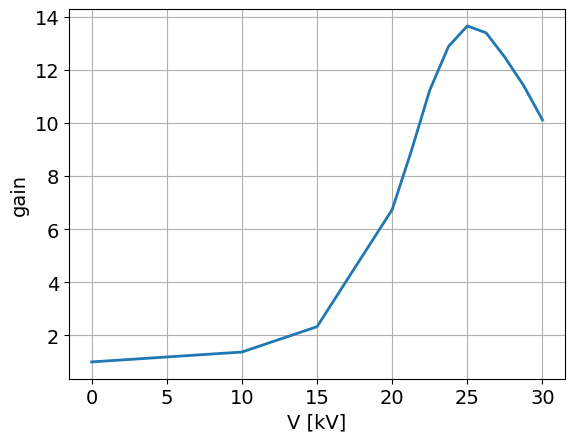

In [ ]:
fig, ax = plt.subplots()
ax.plot(voltages / 1e3, gains, lw=2)

ax.set_xlabel("V [kV]")
ax.set_ylabel("gain")

ax.grid()

In [ ]:
# some Monte-Carlo sampling

n_samples = 1_000

nr_survived_sampled = []
for func in interpolations.values():
    nr_surv = func(amplitude * np.sin(np.linspace(0, 2 * np.pi, 101)) + mean)
    sampled = np.random.normal(
        loc=nr_surv[:, None],
        scale=np.sqrt(nr_surv)[:, None],
        size=(nr_surv.size, n_samples),
    )
    nr_survived_sampled.append(sampled.flatten())
nr_survived_sampled = np.array(nr_survived_sampled)

In [ ]:
nr_survived_sampled.shape


(12, 101000)

In [ ]:
# how many quotient‐samples you want:
n_batch = 10_000

rng = np.random.default_rng()

M, N = nr_survived_sampled.shape
P = N

rng = np.random.default_rng()

# METHOD A: independent sampling of (j,k) for each row
# ---------------------------------------------------
# pick column-indices j and b-indices k for each row independently
j_idx = rng.integers(0, N, size=(M, n_batch))  # which a‐column
k_idx = rng.integers(0, P, size=(M, n_batch))  # which b‐entry

# row numbers 0…M-1 broadcast up
row_idx = np.arange(M)[:, None]  # shape (M,1)

# gather & divide
sampled = (
    nr_survived_sampled[row_idx, j_idx] / nr_survived_sampled[0, :][k_idx]
)  # shape (M, n_samples)

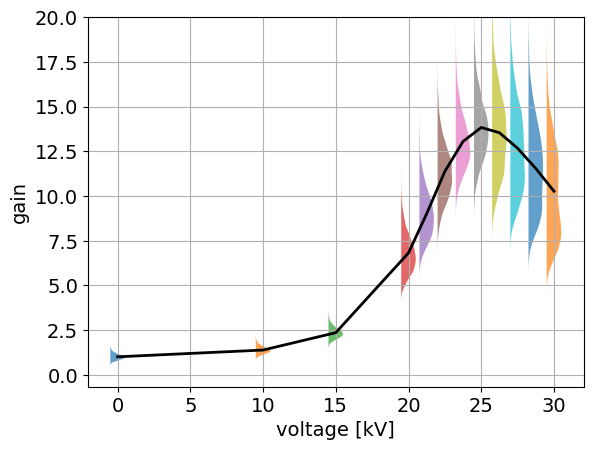

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


def ridgeline(
    sampled,
    xpos,
    n_points=200,
    alpha=0.7,
    figsize=None,
    xlabel="voltage [kV]",
    ylabel="gain",
):
    """
    Make a ridgeline plot of each row in `sampled`.

    Parameters
    ----------
    sampled : ndarray, shape (M, n_samples)
        Your data: each row is one distribution.
    xpos : 1-D array of length M
        The x-coordinate at which the *center* of each one-sided ridge
        (its half-max point) should sit.
    n_points : int
        Number of x–grid points for the KDE.
    alpha : float
        Fill transparency.
    figsize : tuple
        Figure size.
    """
    M, _ = sampled.shape

    # 1) Build a common y-grid covering all your data:
    y_min, y_max = sampled.min(), sampled.max()
    y = np.linspace(y_min, y_max, n_points)

    fig, ax = plt.subplots(figsize=figsize)

    # 2) For each row, estimate a KDE, normalize, and stack it at x=i:
    for i, row in enumerate(sampled):
        xi = xpos[i]
        kde = gaussian_kde(row)
        dens = kde(y)
        dens /= dens.max()  # normalize so peak width = 1

        # shift so that at half-height (dens=0.5) you get exactly x=xi:
        x0 = xi - 0.5
        x1 = x0 + dens

        plt.fill_betweenx(y, x0, x1, alpha=alpha, linewidth=0)

    # 3) Ticks & labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return fig, ax


# — Usage (assuming you already have `sampled` loaded) —
fig, ax = ridgeline(sampled, voltages / 1e3)
ax.plot(voltages / 1e3, sampled.mean(axis=1), lw=2, color="k")
ax.set_ylim(ymax=20)
ax.grid()

## Include residual population

In [ ]:
nr_survived = np.array(
    [
        [[len(d[1]) for d in dat[key_mF]] for key_mF in dat.keys()]
        for key, dat in data.items()
    ]
)

# assume 10% remaining in mF=+/-2 and mF=+/-3
factors = np.array([3 + 0.8 * 4, 2 * 0.2, 2 * 0.2])

nr_survived_weighted = np.sum(factors[None, :, None] * nr_survived, axis=1)

# 2) variance along axis=1 → shape (K, M)
var_S = np.sum((factors[None, :, None] ** 2) * nr_survived, axis=1)

# 3) propagated 1σ error
nr_survived_weighted_error = np.sqrt(var_S)

# 4) calculate gains
# 1) grab the per‐row denominators (col 0 → shape (K,)) and broadcast to (K,M)
denom = nr_survived_weighted[:, 0][:, None]  # shape (K,1) → (K,M) when dividing
sigma_denom = nr_survived_weighted_error[:, 0][:, None]  # likewise

# 2) compute gain and its 1σ error
gains = nr_survived_weighted / denom

gains_error = gains * np.sqrt(
    (nr_survived_weighted_error / nr_survived_weighted)
    ** 2  # relative error of numerator, shape (K,M)
    + (sigma_denom / denom)
    ** 2  # relative error of denominator, shape (K,1) → broadcast
)


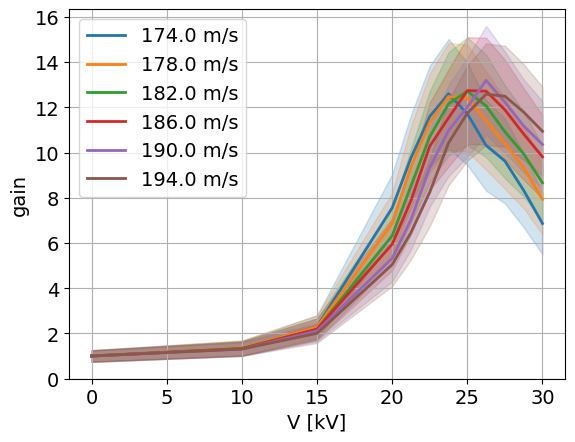

In [ ]:
sl = np.s_[::2]
fig, ax = plt.subplots()
for vf, g, ge in zip(vforwards[sl], gains[sl], gains_error[sl]):
    (l,) = ax.plot(voltages / 1e3, g, lw=2, label=f"{vf:.1f} m/s")
    ax.fill_between(
        voltages / 1e3,
        g - 2 * ge,
        g + 2 * ge,
        alpha=0.2,
        edgecolor=l.get_color(),
        facecolor=l.get_color(),
    )

ax.set_xlabel("V [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid()


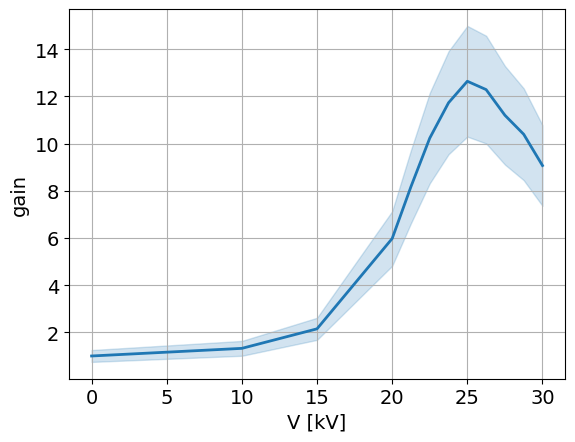

In [ ]:
fig, ax = plt.subplots()
(l,) = ax.plot(voltages / 1e3, gains[5], lw=2)
ax.fill_between(
    voltages / 1e3,
    gains[5] - 2 * gains_error[5],
    gains[5] + 2 * gains_error[5],
    alpha=0.2,
    edgecolor=l.get_color(),
    facecolor=l.get_color(),
)

ax.set_xlabel("V [kV]")
ax.set_ylabel("gain")
ax.grid()
